Confirm that the simulated spectra generated using dark/bright sky are sensible

In [1]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in GAMA-legacy catalog for the meta data

In [3]:
cata = Cat.GamaLegacy()
gleg = cata.Read()

In [4]:
redshift = gleg['gama-spec']['z_helio']
ngal = len(redshift)
print('%i galaxies total' % ngal)

39832 galaxies total


In [39]:
band_list = ['b', 'r', 'z']

Read in dark sky simulated spectra for galaxy `i_gal`

In [5]:
i_gal = 128

In [6]:
f_darkspec = ''.join([UT.dat_dir(), 'spectra/', 
                     'gama_legacy.expSpectra.darksky.seed1.1of40blocks.fits'])
darkspec = read_spectra(f_darkspec)

read in bright sky simulated spectra for galaxy `i_gal`

In [9]:
f_brightspec = ''.join([UT.dat_dir(), 'spectra/', 
                     'gama_legacy.expSpectra.brightsky.seed1.1of40blocks.fits'])
brightspec = read_spectra(f_brightspec)

In [43]:
for k in darkspec.fibermap.keys(): 
    if not np.array_equal(darkspec.fibermap[k], brightspec.fibermap[k]):
        print('%s' % k )

(-5.0, 10)

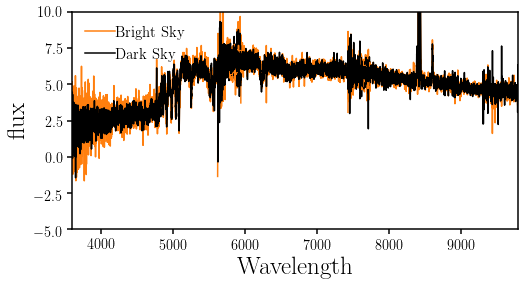

In [41]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
for band in band_list:
    sub.plot(brightspec.wave[band], brightspec.flux[band][i_gal].flatten(), c='C1', label='Bright Sky')
    sub.plot(darkspec.wave[band], darkspec.flux[band][i_gal].flatten(), c='k', label='Dark Sky')    
    if band == 'b': sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size': 15})
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim([-5., 10])

[]

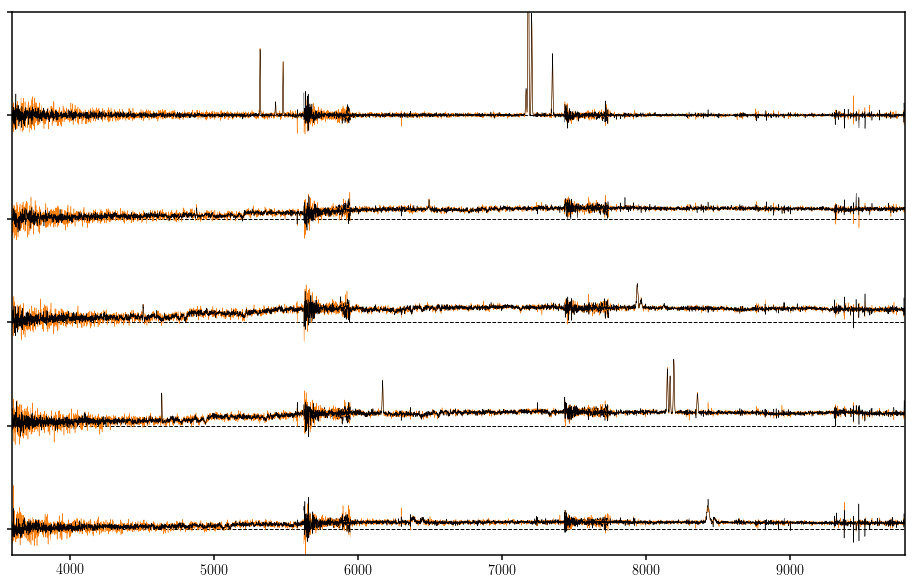

In [42]:
fig = plt.figure(figsize=(16,10))
sub = fig.add_subplot(111)
for iii, ii in enumerate(np.random.choice(range(brightspec.flux['b'].shape[0]), size=5)): 
    sub.plot([0., 100000.], [20.*float(iii), 20.*float(iii)], c='k', lw=1, ls='--')
    for band in band_list:
        sub.plot(brightspec.wave[band], brightspec.flux[band][ii].flatten()+20.*float(iii), lw=0.5, c='C1')
        sub.plot(darkspec.wave[band], darkspec.flux[band][ii].flatten()+20.*float(iii), lw=0.5, c='k')
sub.set_xlim([3600., 9800.])
sub.set_ylim([-5., 100])
sub.set_yticklabels([])

In [44]:
obj16_bright = read_spectra(''.join([UT.dat_dir(), 'weird_obj89.brightsky.fits']))
obj16_dark = read_spectra(''.join([UT.dat_dir(), 'weird_obj89.darksky.fits']))

(0.0, 20.0)

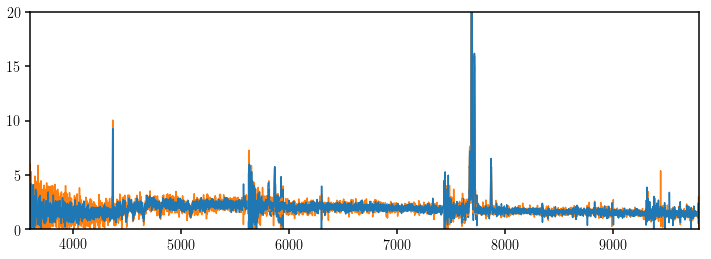

In [45]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(111)
for band in band_list: 
    sub.plot(obj16_bright.wave[band], obj16_bright.flux[band][0].flatten(), c='C1')#, s=0.5)
    sub.plot(obj16_dark.wave[band], obj16_dark.flux[band][0].flatten(), c='C0')#, s=0.5)
sub.set_xlim([3600., 9800.])
sub.set_ylim([0., 20.])